# Human Pose Estimation

[MPll Human Pose Dataset](http://human-pose.mpi-inf.mpg.de/#download)을 사용

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### TFRecord 준비

In [2]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0])
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0])
        for joint in anno['joints']
    ]
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

@ray.remote
def build_single_tfrecord(chunk, path):
    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())


def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, 
            '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                    split,
                    str(i + 1).zfill(4),
                    str(total_shards).zfill(4),
                )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [3]:
def make_trrecord():
    with open(TRAIN_JSON) as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, IMAGE_PATH)
            for anno in train_annos
        ]

    with open(TRAIN_JSON) as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, IMAGE_PATH) for anno in val_annos
        ]
        
    build_tf_records(train_annotations, 64, 'train')
    build_tf_records(val_annotations, 8, 'val')

### 데이터 전처리 모듈 만들기

In [4]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SHAPE = (64, 64, 16)

In [5]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=IMAGE_SHAPE,
                 heatmap_shape=HEATMAP_SHAPE,
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        return image, heatmaps

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'imaage/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)

    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0

        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]

        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return image, effective_keypoint_x, effective_keypoint_y

    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)

        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)

        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])

        return heatmaps

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        
        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(
            -(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                                 dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1

        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)

        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)

        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])

        return heatmaps

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)

---
## 모델 생성 함수 만들기
### 1. Hourglass 모델

In [6]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(input_shape=IMAGE_SHAPE, num_stack=4,
                            num_residual=1, num_heatmap=16):
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

### 2. SimpleBaseLine 모델

In [7]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()

    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())

    return seq_model


def Simplebaseline(input_shape=IMAGE_SHAPE, num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')(inputs)
    x = _make_deconv_layer(3)(x)
    out = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')(x)
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

---
## 모델 학습 함수 만들기

In [8]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

### 1. Hourglass 모델

In [9]:
class HGTrainer(object):
    def __init__(self,
                 model,
                 history,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.history = history
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        if type(outputs)!=list:
            outputs = [outputs]
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(tf.math.square(labels - output) * weights) * (1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                if num_train_batches % 100 == 0:
                    tf.print('Trained batch', num_train_batches, 'batch loss', batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                if num_val_batches % 100 == 0:
                    tf.print('Validated batch', num_val_batches, 'batch loss', batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            self.history['loss'].append(train_loss)
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            self.history['val_loss'].append(val_loss)
            tf.summary.scalar('epoch val loss', val_loss)

            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = './models/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(IMAGE_SHAPE, (HEATMAP_SHAPE[0], HEATMAP_SHAPE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [10]:
def hg_train(history, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        model.summary()

        trainer = HGTrainer(
            model,
            history,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        trainer.run(train_dist_dataset, val_dist_dataset)
        return model

### 2. SimpleBaseLine 모델

In [11]:
class SBTrainer(object):
    def __init__(self,
                 model,
                 history,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.history = history
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        if type(outputs)!=list:
            outputs = [outputs]
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(tf.math.square(labels - output) * weights) * (1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                if num_train_batches % 100 == 0:
                    tf.print('Trained batch', num_train_batches, 'batch loss', batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                if num_val_batches % 100 == 0:
                    tf.print('Validated batch', num_val_batches, 'batch loss', batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            self.history['loss'].append(train_loss)
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            self.history['val_loss'].append(val_loss)
            tf.summary.scalar('epoch val loss', val_loss)

            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = './models/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(IMAGE_SHAPE, (HEATMAP_SHAPE[0], HEATMAP_SHAPE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [12]:
def sb_train(history, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        model = Simplebaseline()
        model.summary()

        trainer = SBTrainer(
            model,
            history,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        trainer.run(train_dist_dataset, val_dist_dataset)
        return model

---
## 모델 test 함수 만들기

In [13]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],

    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [14]:
TEST_IMAGE = os.path.join(PROJECT_PATH, 'test_image.jpg')

---
## 시각화 함수 만들기

In [21]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()


def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

---
## 모델 완성 후 학습

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 3
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007

automatic_gpu_usage()

1 Physical GPUs, 1 Logical GPUs


#### TFRecord

In [17]:
ray.init()
make_trrecord()

2022-04-25 08:06:47,548	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.45gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
(pid=557) 2022-04-25 08:06:52.666658: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=556) 2022-04-25 08:06:53.078243: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=558) 2022-04-25 08:06:53.088091: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is det

#### Hourglass

In [18]:
hg_history_map = {'loss': [], 'val_loss': []}
hg_model = hg_train(hg_history_map, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

re_lu_182 (ReLU)                (None, 32, 32, 128)  0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 32, 32, 128)  147584      re_lu_182[0][0]                  
__________________________________________________________________________________________________
batch_normalization_183 (BatchN (None, 32, 32, 128)  512         conv2d_193[0][0]                 
__________________________________________________________________________________________________
re_lu_183 (ReLU)                (None, 32, 32, 128)  0           batch_normalization_183[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 32, 32, 256)  33024       re_lu_183[0][0]                  
__________________________________________________________________________________________________
add_62 (Ad

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 100 batch loss 3.58953738 epoch total loss 3.55689454
Trained batch 200 batch loss 3.29500842 epoch total loss 3.40934014
Trained batch 300 batch loss 3.34416747 epoch total loss 3.35032177
Trained batch 400 batch loss 3.08560038 epoch total loss 3.30354762
Trained batch 500 batch loss 3.0291326 epoch total loss 3.26198745
Trained batch 600 batch loss 3.20150423 epoch total loss 3.21816897
Trained batch 700 batch loss 2.68105102 epoch total loss 3.19235659
Trained batch 800 batch loss 2.97372293 epoch total loss 3.16804314
Trained batch 900 batch loss 3.03716326 epoch total loss 3.14331889
Trained batch 1000 batch loss 2.78943491 epoch total loss 3.11989975
Trained batch 1100 batch loss 2.60813761 epoch total loss 3.10913801
Trained batch 1200 batch loss 2.91502666 epoch total loss 3.09615064
Trained batch 1300 batch loss 2.96742058 epoch total loss 3.08122849
Trained batch 1400 batch loss 2.70430517 epoch total loss 3.06228
Trained batch 15

Epoch 3 train loss 2.4408321380615234
Validated batch 100 batch loss 2.58181381
Validated batch 200 batch loss 2.44439483
Validated batch 300 batch loss 2.6618259
Validated batch 400 batch loss 2.34280634
Validated batch 500 batch loss 2.33985496
Validated batch 600 batch loss 1.76055551
Validated batch 700 batch loss 2.6132493
Validated batch 800 batch loss 2.84072709
Validated batch 900 batch loss 1.88038433
Validated batch 1000 batch loss 2.50700188
Validated batch 1100 batch loss 2.51654458
Validated batch 1200 batch loss 2.03431773
Validated batch 1300 batch loss 2.51921
Validated batch 1400 batch loss 2.58258629
Validated batch 1500 batch loss 2.58110642
Validated batch 1600 batch loss 2.55482936
Validated batch 1700 batch loss 2.46017766
Validated batch 1800 batch loss 2.41863298
Validated batch 1900 batch loss 2.3914659
Validated batch 2000 batch loss 3.04509449
Validated batch 2100 batch loss 2.29989266
Validated batch 2200 batch loss 2.75295091
Validated batch 2300 batch loss

#### SimpleBaseLine

In [19]:
sb_history_map = {'loss': [], 'val_loss': []}
sb_model = sb_train(sb_history_map, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
94781440/94765736 [==============================] - 0s 0us/step
Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________
Start training...
Start epoch 1 with learning rate 0.0007
Start d

Trained batch 600 batch loss 0.529524922 epoch total loss 0.600663841
Trained batch 700 batch loss 0.484036148 epoch total loss 0.598975599
Trained batch 800 batch loss 0.553099632 epoch total loss 0.599232197
Trained batch 900 batch loss 0.567090094 epoch total loss 0.599871159
Trained batch 1000 batch loss 0.627792239 epoch total loss 0.599539638
Trained batch 1100 batch loss 0.531422615 epoch total loss 0.597873032
Trained batch 1200 batch loss 0.711897612 epoch total loss 0.598922
Trained batch 1300 batch loss 0.638593435 epoch total loss 0.597383261
Trained batch 1400 batch loss 0.591182351 epoch total loss 0.596521556
Trained batch 1500 batch loss 0.609204948 epoch total loss 0.596787691
Trained batch 1600 batch loss 0.582977653 epoch total loss 0.596408069
Trained batch 1700 batch loss 0.539212644 epoch total loss 0.597177625
Trained batch 1800 batch loss 0.568542 epoch total loss 0.595412
Trained batch 1900 batch loss 0.52381146 epoch total loss 0.594478786
Trained batch 2000 b

---
### 모델 test

#### Hourglass

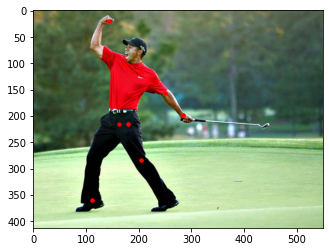

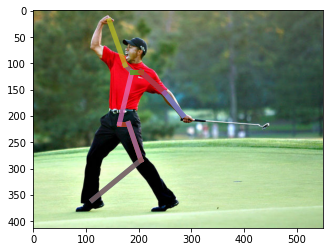

In [22]:
image, keypoints = predict(hg_model, TEST_IMAGE)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

#### SimpleBaseLine

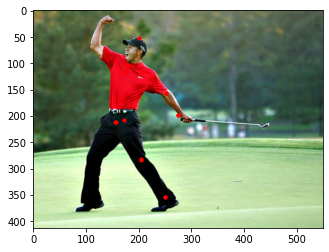

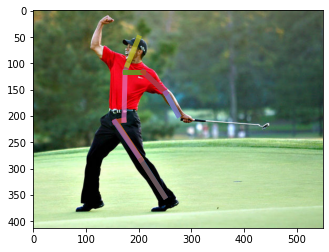

In [23]:
image, keypoints = predict(sb_model, TEST_IMAGE)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

---
### loss값 비교

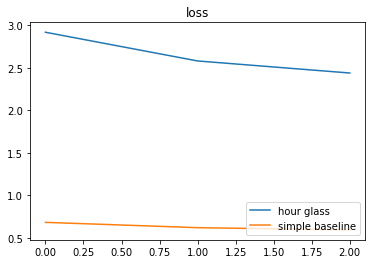

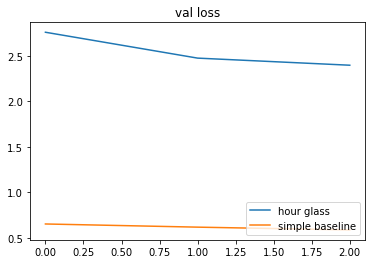

In [26]:
plt.title('loss')
plt.plot(hg_history_map['loss'], label='hour glass')
plt.plot(sb_history_map['loss'], label='simple baseline')
plt.legend(loc='lower right')
plt.show()
    
plt.title('val loss')
plt.plot(hg_history_map['val_loss'], label='hour glass')
plt.plot(sb_history_map['val_loss'], label='simple baseline')
plt.legend(loc='lower right')
plt.show()